# Two-stage rocket ascent
Copyright (c) 2010-2022, Delft University of Technology. All rights reserved. This file is part of the Tudat. Redistribution and use in source and binary forms, with or without modification, are permitted exclusively under the terms of the Modified BSD license. You should have received a copy of the license with this file. If not, please or visit: http://tudat.tudelft.nl/LICENSE.

## Context
This example demonstrates the simulation of the ascent trajectory of a two stage rocket on Mars. Two simulations are carried: one for each stage. In these simulations, both the dynamic state and the mass of the vehicle are propagated.

To ascent to orbit, the rocket needs thrust. This example thus also focuses on demonstrating various ascpect of thrust that are available in Tudat(Py). More specifically, dual thrust is implemented, simulating a solid propellant which burns with a magnitude 1.75 times higher in the 15 first seconds.

Aerodynamic guidance is also included, as to very simply update the angle of attack of the vehicle over time, simulating an oscillation between -2deg and 2deg.

A custom termination setting is also showcased, used to switch from the first stage to the second stage when apogee is reached.

## Import statements
The required import statements are made here, at the very beginning.

Some standard modules are first loaded. These are `numpy`, `matplotlib.pyplot`, and `datetime.datetime`.

Then, the different modules of `tudatpy` that will be used are imported.

In [1]:
# Load standard modules
import numpy as np

from matplotlib import pyplot as plt
from datetime import datetime

# Load tudatpy modules
from tudatpy.kernel.interface import spice
from tudatpy.kernel import numerical_simulation
from tudatpy.kernel.numerical_simulation import environment, environment_setup, propagation, propagation_setup
from tudatpy.kernel.astro import element_conversion, time_conversion
from tudatpy.kernel import constants
from tudatpy.util import result2array

## Configuration
NAIF's `SPICE` kernels are first loaded, so that the position of various bodies such as the Earth can be make known to `tudatpy`.

Then, the start and end simulation epochs are setups. In this case, the start epoch is set to the 17th of February 2031. This epoch is first defined using the `datetime` module. Because the times should be specified in seconds since J2000, the `time_conversion module` is then used to convert the `datetime` to the correct format.

In [2]:
# Load spice kernels
spice.load_standard_kernels()

# Set simulation start as the 17th of February 2031
simulation_start_datetime = datetime(2031, 2, 17)
# Convert simulation start to Julian Days
simulation_start_JD = time_conversion.calendar_date_to_julian_day(simulation_start_datetime)
# Convert simulation start to seconds since J2000
simulation_start_epoch = time_conversion.julian_day_to_seconds_since_epoch(simulation_start_JD)

## Environment setup
Let’s create the environment for our simulation. This setup covers the creation of (celestial) bodies, vehicle(s), and environment interfaces.

### Create the bodies
Bodies can be created by making a list of strings with the bodies that is to be included in the simulation.

The default body settings (such as atmosphere, body shape, rotation model) are taken from `SPICE`.

These settings can be adjusted. Please refere to the [Available Environment Models](https://tudat-space.readthedocs.io/en/latest/_src_user_guide/state_propagation/environment_setup/create_models/available.html#available-environment-models) in the user guide for more details.

For our central body Mars, a predefined exponential atmosphere is then loaded.

Finally, the system of bodies is created using the settings. This system of bodies is stored into the variable `bodies`.

In [3]:
# Define a function to create a default system of bodies (so it can be reused later)
def create_bodies():
    # Define string names for bodies to be created from default.
    bodies_to_create = ["Mars"]

    # Use "Earth"/"J2000" as global frame origin and orientation.
    global_frame_origin = "Mars"
    global_frame_orientation = "J2000"

    # Create default body settings, usually from `spice`.
    body_settings = environment_setup.get_default_body_settings(
        bodies_to_create,
        global_frame_origin,
        global_frame_orientation
    )

    # Add a predefined exponential atmosphere model for Mars
    body_settings.get("Mars").atmosphere_settings = environment_setup.atmosphere.exponential_predefined("Mars")

    # Return the system of selected celestial bodies
    return environment_setup.create_system_of_bodies(body_settings)
    
# Create the system of selected celestial bodies
bodies = create_bodies()

## First section simulation
In this example, our rocket consists of two stages. Do note that, further, the nomenclature of rocket **sections** is used, rather than rocket **stages**. The first rocket section contains both the first and the second stage. The second rocket section contains only the second stage. Section 1 is thus before stage separation, and section 2 after.

Two distinct propagations will be made, one for each rocket section. The first section is numerically propagated until stage separation at apogee. Then, the second rocket section is propagated with a different body, with different properties, starting from where the first section stopped.

In a first time, we will thus focus on the ascent of the first section. Many functions will be defined in this example to setup the propagation of the first section. This is because the second section uses a similar setup, and will later re-use these functions.

### Create the vehicle
Let's now create our vehicle for the first section, called "Section 1". It has an initial mass of 370kg.

In [4]:
# Define a function to create a body for a rocket section
def create_rocket_section(section_name, wet_mass):
    # Create an empty body with the given section name
    bodies.create_empty_body(section_name)
    # Assign the initial mass of the body (the section wet mass)
    bodies.get(section_name).mass = wet_mass

# Create the first rocket section body with a wet mass of 370kg
create_rocket_section("Section 1", 370.0)

To account for the aerodynamic of the first section, let's add an aerodynamic interface to the environment setup, taking the followings into account:
- A constant drag coefficient of 0.85.
- No sideslip coefficient (equal to 0).
- A lift coefficient of 0.4.
- A reference area of 0.25m$^2$.
- No moment coefficient.

In [5]:
# Define a function to add an aerodynamic coefficient interface with the coefficient of a given section
def add_aero_coefficients(section_name, CD, CL, ref_area=0.25):
    # Create aerodynamic coefficient interface settings
    aero_coefficient_settings = environment_setup.aerodynamic_coefficients.constant(
        ref_area,
        [CD, 0, CL]
    )
    # Add the aerodynamic coefficient interface settings to the environment, linked to the rocket section
    environment_setup.add_aerodynamic_coefficient_interface(
        bodies,
        section_name,
        aero_coefficient_settings
    )

# Create an aerodynamic coefficient interface for the first rocket section
add_aero_coefficients("Section 1", 0.85, 0.4)

### Propagation setup
Now that the environment is created, the propagation setup is defined.

First, the bodies to be propagated and the central bodies will be defined.
Central bodies are the bodies with respect to which the state of the respective propagated bodies is defined.

The body to be propagated in the first part of this example is the first rocket section.

In [6]:
# Define bodies that are propagated
bodies_to_propagate = ["Section 1"]

# Define central bodies of propagation
central_bodies = ["Mars"]

#### Thrust model
Let's now define a thrust class, which will contain all of the functions needed to fully define a custom thrust model.

As always in an ascent problem, we cannot use thrust anymore when the current stage has exhausted its propellant. The first function, `is_thrust_on()`, returns True when thrust can be used, and False when all of the propellant has been used.

Then, the `get_thrust_magnitude()` function returns the current thrust magnitude. This magnitude is 1.75 times higher in the first 15 seconds, simulating the dual thrust of a solid propellant motor. This results in the following function for the thrust over time, with the time since engine start $t$ in seconds, and the user-set thrust magnitude $F_{T_\text{set}}$ in Newtons:
$$
F_T(t) = 
\begin{cases}
1.75 \cdot F_{T_\text{set}} & \text{if }t < 15 \\
F_{T_\text{set}} & \text{if }t \geq 15
\end{cases}
$$

The constant specific impulse is returned by the `get_specific_impulse()` function.

Finally, the `get_thrust_direction()` returns the angle of the thrust in the **inertial frame**, as defined by the `vertical_angle` variable that specifies the angle of the thrust w.r.t. the axis going from the vehicle to the centre of Mars (the **vertical frame**). This unit vector that represents the thrust angle in the inertial frame $\hat{\mathbf{f}}_T$ is computed as below, with the rotation matrix from the vertical frame to the inertial frame $\mathbf{R}^{I/V}$ and the specified thrust angle in the vertical frame $\alpha_V$.

$$
\hat{\mathbf{f}}_T = \mathbf{R}^{I/V} \cdot 
\begin{bmatrix}
0 \\
\sin \alpha_V \\
-\cos \alpha_V
\end{bmatrix}
$$

In [25]:
class thrust_model:

    def __init__(self, magnitude, Isp, vertical_angle, propagated_body, section_dry_mass):
        self.magnitude = magnitude               # Thrust magnitude [N]
        self.Isp = Isp                           # Specific impulse [s]
        self.vertical_angle = vertical_angle     # Angle from the vertical [rad]
        self.propagated_body = propagated_body   # Body that is being propagated (tudatpy.numerical_simulation.environment.Body)
        self.section_dry_mass = section_dry_mass # Dry mass of the section [kg]
        self.t0 = None                           # Initial burn time for this section [s]

    def is_thrust_on(self, time):
        # The thrust is on (true) if the current section mass is strictly greater than its dry mass
        return self.propagated_body.mass > self.section_dry_mass

    def get_thrust_magnitude(self, time):
        # If we are in the 15 first seconds, return 1.75 times the magnitude
        # print(time)
        if self.t0 is None:
            self.t0 = time
        if time - self.t0 < 15:
            return 1.75*self.magnitude
        return self.magnitude

    def get_specific_impulse(self, time):
        # Return the constant specific impulse
        return self.Isp

    def get_thrust_direction(self, time):
        # Get aerodynamic angle calculator
        print(time)
        aerodynamic_angle_calculator = self.propagated_body.flight_conditions.aerodynamic_angle_calculator
        
        # Set thrust in vertical frame and transpose it
        thrust_direction_vertical_frame = np.array([[0, np.sin(self.vertical_angle), - np.cos(self.vertical_angle)]]).T
        
        # Retrieve rotation matrix from vertical to inertial frame from the aerodynamic angle calculator
        vertical_to_inertial_frame = aerodynamic_angle_calculator.get_rotation_matrix_between_frames(
            environment.AerodynamicsReferenceFrames.vertical_frame,
            environment.AerodynamicsReferenceFrames.inertial_frame)
        
        print(vertical_to_inertial_frame)
        
        # Compute the thrust in the inertial frame
        thrust_inertial_frame = np.dot(vertical_to_inertial_frame,
                                    thrust_direction_vertical_frame)
        # Return the thrust direction in the inertial frame
        return thrust_inertial_frame

#### Define the thrust settings
Using the `thrust_model` class that was defined earlier, we can now define thrust acceleration settings for the first rocket section.

For this first section, the following parameters are used for the thrust:
- A thrust magnitude of 4.25 kN.
- A specific impulse of 275 seconds.
- A constant thrust angle of 40 deg from the vertical.
- A dry mass of the first section of 185 kg (note that the wet mass was defined as 370 kg, so 185 kg of propellant can be used).

In [26]:
# Define a function to create acceleration settings based on the direction and magnitude from the custom thrust class
def create_body_settings_for_thrust(current_thrust_model, bodies, body_name):
    # Define the thrust direction settings for the first section from the custom direction function
    rotation_model_settings = environment_setup.rotation_model.custom_inertial_direction_based(
        current_thrust_model.get_thrust_direction,
                "J2000", "VehicleFixed"
    )
    
    environment_setup.add_rotation_model( bodies, body_name, rotation_model_settings )


    # Define the thrust magnitude settings for the first section from the custom functions
    thrust_magnitude_settings = propagation_setup.thrust.custom_thrust_magnitude(
        current_thrust_model.get_thrust_magnitude,
        current_thrust_model.get_specific_impulse
    )
    
    environment_setup.add_engine_model(
    body_name,
    "MainEngine",
    thrust_magnitude_settings,
    bodies )


# Setup the thrust model for the first section
current_thrust_model = thrust_model(4250, 275, np.deg2rad(40), bodies.get("Section 1"), 185)
create_body_settings_for_thrust(current_thrust_model, bodies, "Section 1")

#### Create the accelerations model
First off, the acceleration settings from the environment that act on the rocket are to be defined.
In this case, these consist in the two followings:
- Graviational acceleration of Mars modeled as Spherical Harmonics, taken up to a degree and order 4.
- Aerodynamic acceleration caused by the atmosphere of Mars (using the aerodynamic interface defined earlier).

Additional accelerations are then added for the first rocket section, containing the thrust acceleration settings that were defined earlier.

The acceleration settings defined are then applied to the rocket section, and acceleration models are created.

In [27]:
# Define a function to create acceleration models for a given rocket section, containing the thrust
def create_section_accelerations(section_name):
    # Duplicate the environmental accelerations (use copy to avoiding keeping the same dict linked to both sections)
    accelerations_on_rocket = {
        "Mars": [
            propagation_setup.acceleration.spherical_harmonic_gravity(4, 4),
            propagation_setup.acceleration.aerodynamic()
        ],
        section_name: [
            propagation_setup.acceleration.thrust_from_all_engines( )
        ]
    }

    # Create acceleration models for the given section
    return propagation_setup.create_acceleration_models(
        bodies,
        {section_name: accelerations_on_rocket},
        bodies_to_propagate,
        central_bodies
    )


# Define the acceleration models for the first rocket section
acceleration_models = create_section_accelerations("Section 1")


### Define the initial state
The initial state of the rocket for which the ascent will be propagated is now defined. 

This initial state always has to be provided as a cartesian state, in the form of a list with the first three elements reprensenting the initial position, and the three remaining elements representing the initial velocity.

In this case, let's make use of the `spherical_to_cartesian_elementwise()` function that is included in the `element_conversion` module, so that the initial state can be input as Spherical elements, and then converted in Cartesian elements.

The initial state that will be defined is the one of the entire rocket, which is the same as the one used for the first section.

In [28]:
# Define the initial state in Spherical elements, and convert to Mars fixed Cartesian elements
initial_mars_fixed_state = element_conversion.spherical_to_cartesian_elementwise(
    radial_distance=bodies.get_body("Mars").shape_model.average_radius + 500,
    latitude=np.deg2rad(18.85),
    longitude=np.deg2rad(77.52),
    speed=1.0,
    flight_path_angle=np.deg2rad(40),
    heading_angle=0
)

# Convert the Mars fixed initial state to the inertial frame
initial_inertial_state = environment.transform_to_inertial_orientation(
    initial_mars_fixed_state, simulation_start_epoch, bodies.get_body("Mars").rotation_model
)

### Define dependent variables to save
Different dependent variables can be saved alongside the state of the vehicle during the propagation. In this example, we are particularily interested in saving the altitude, airspeed, dynamic pressure, and mass of the first rocket section. In addition, various acceleration norms are defined to be saved as dependent variables.

In [29]:
# Define a function to return the list of dependent variables to save for a given section
def define_dependent_variables_to_save(section_name):
    return [
        propagation_setup.dependent_variable.altitude( section_name, "Mars" ),
        propagation_setup.dependent_variable.airspeed( section_name, "Mars" ),
        propagation_setup.dependent_variable.dynamic_pressure( section_name ),
        propagation_setup.dependent_variable.body_mass( section_name ),
        propagation_setup.dependent_variable.total_acceleration_norm( section_name ),
        propagation_setup.dependent_variable.single_acceleration_norm(
            propagation_setup.acceleration.spherical_harmonic_gravity_type, section_name, "Mars"),
        propagation_setup.dependent_variable.single_acceleration_norm(
            propagation_setup.acceleration.thrust_acceleration_type, section_name, section_name),
        propagation_setup.dependent_variable.single_acceleration_norm(
            propagation_setup.acceleration.aerodynamic_type, section_name, "Mars")
    ]
    
# Define the dependent variables to save for the first rocket section
dependent_variables_to_save = define_dependent_variables_to_save("Section 1")

### Define termination settings
Termination settings define the conditions that, once reached, will stop the propagation.

In this case, for the first rocket section, two termination settings are used:
- Stop when the vehicle starts falling again, indicating that it reached apogee.
- Stop 225 minutes after lift-off.

In [30]:
class vehicle_falling:
    
    def __init__(self, body, initial_time):
        # Initialise the class used to compute wether a body is falling or not
        self.body = body
        self.last_h = -np.inf
        self.init_t = initial_time
        
    def is_it_falling(self, time):
        # Compute the difference in altitude since this function was last called
        dh = self.body.flight_conditions.altitude - self.last_h
        self.last_h = self.body.flight_conditions.altitude
        # Compute how far from lift-off we are
        time_elapsed = time - self.init_t
        # Return True (vehicle is falling) if the vehicle looses altitude, and lift-off was more than a second ago
        return dh < 0 and time_elapsed > 1

# Define a termination setting based on the custom function defining wether the vehicle falls or not
vehicle_falling_model = vehicle_falling(bodies.get("Section 1"), simulation_start_epoch)
termination_apogee_settings = propagation_setup.propagator.custom_termination(vehicle_falling_model.is_it_falling)

# Define a termination setting to stop 225 minutes after lift-off
end_epoch = simulation_start_epoch + 225*60
termination_max_time_settings = propagation_setup.propagator.time_termination(end_epoch)

# Combine both termination settings into a hybrid termination
combined_termination_settings = propagation_setup.propagator.hybrid_termination(
    [termination_apogee_settings, termination_max_time_settings],
    fulfill_single_condition=True
)

### Create integrator settings
Let's now create integrator settings. These use a RK78 intergration scheme with a variable step size. The following settings are used:
- An initial time step of 0.25 seconds.
- A minimum time step of 1e-4 seconds.
- A maximum time step of 100 seconds.
- A relative and absolute error tolerance of 1e-13.

In [31]:
# Define integrator settings with the initial integration epoch
def define_integrator_settings():
    initial_time_step = 0.25
    minimum_time_step = 1e-5
    maximum_time_step = 100
    return propagation_setup.integrator.runge_kutta_variable_step_size(
        initial_time_step,
        propagation_setup.integrator.rkf_78,
        minimum_time_step,
        maximum_time_step,
        relative_error_tolerance=1e-14,
        absolute_error_tolerance=1e-14)

# Define the integrator settings
integrator_settings = define_integrator_settings()

### Create propagator settings
The acceleration models, the initial state, the dependent variables, and the termination settings can now all be combined to define translational propagation settings.
Also, in this case, a Cowell propagator is selected.

Since we use thrust, we also define mass propagation settings, with the mass rate being setup to be consistant with the thrust.

The translational and mass propagation settings are combined together, to propagate both in the same propagation.

In [32]:
# Define a function to create translational and mass propagation settings for a given rocket section
def create_propagator_settings(section_name, initial_state, simulation_start_epoch, initial_mass, termination_settings, integrator_settings):
    # Define the translational propagator settings with a Cowell propagator
    translational_propagator_settings = propagation_setup.propagator.translational(
        central_bodies,
        acceleration_models,
        bodies_to_propagate,
        initial_state,
        simulation_start_epoch,
        integrator_settings,
        termination_settings,
        propagation_setup.propagator.cowell,
        output_variables=dependent_variables_to_save
    )
    # Define a mass rate model so that the mass lost by the rocket is consistant with its thrust and specific impulse
    mass_rate_settings = {section_name:[propagation_setup.mass_rate.from_thrust()]}
    mass_rate_models = propagation_setup.create_mass_rate_models(
        bodies,
        mass_rate_settings,
        acceleration_models
    )
    # Define the mass propagator settings, taking the initial section mass into account
    mass_propagator_settings = propagation_setup.propagator.mass(
        bodies_to_propagate,
        mass_rate_models,
        [initial_mass],
        simulation_start_epoch,
        integrator_settings,
        termination_settings
    )
    # Return the translational and mass propagator settings combined
    return propagation_setup.propagator.multitype(
        [translational_propagator_settings, mass_propagator_settings],
        integrator_settings,
        simulation_start_epoch,
        termination_settings,
        dependent_variables_to_save
    )
    
# Define the translational and mass propagator settings for the first rocket section
propagator_settings = create_propagator_settings("Section 1", initial_inertial_state, simulation_start_epoch, 370, combined_termination_settings, integrator_settings)

### Run the first section ascent
With everything being now setup, we can finally run the ascent simulation of the first rocket section (containing both the first and the second stage). This is done by calling the `create_dynamics_simulator()` function.

The state and dependent variables history is then extracted from the dynamics simulator, and converted to multi-dimensional numpy arrays, using the `result2array()` from tudatpy utils. Do mind that using `result2array` will shift all elements by 1 column to the right, since a first column will be added, containing the apochs.

In [33]:
# Run the numerical simulation of the first rocket section
dynamics_simulator = numerical_simulation.create_dynamics_simulator(
    bodies,
    propagator_settings
)
# Extract the propagated states and dependent variables and convert them to numpy arrays
states = dynamics_simulator.state_history
states_array_section_1 = result2array(states)
dep_vars = dynamics_simulator.dependent_variable_history
dep_vars_array_section_1 = result2array(dep_vars)

nan
[[ 0.52442349  0.83666983  0.15799874]
 [-0.09524715 -0.12675292  0.98735084]
 [ 0.84611346 -0.5328389   0.01321821]]
nan
[[ 0.52442349  0.83666983  0.15799874]
 [-0.09524715 -0.12675292  0.98735084]
 [ 0.84611346 -0.5328389   0.01321821]]
982324800.0
[[ 0.55921562  0.78811051  0.25721533]
 [-0.10038103 -0.24361033  0.96466453]
 [ 0.82292256 -0.56527501 -0.05711936]]
nan
[[ 0.55921562  0.78811051  0.25721533]
 [-0.10038103 -0.24361033  0.96466453]
 [ 0.82292256 -0.56527501 -0.05711936]]
nan
[[ 0.55921562  0.78811051  0.25721533]
 [-0.10038103 -0.24361033  0.96466453]
 [ 0.82292256 -0.56527501 -0.05711936]]
982324800.0
[[ 0.55921562  0.78811051  0.25721533]
 [-0.10038103 -0.24361033  0.96466453]
 [ 0.82292256 -0.56527501 -0.05711936]]
nan
[[ 0.55921562  0.78811051  0.25721533]
 [-0.10038103 -0.24361033  0.96466453]
 [ 0.82292256 -0.56527501 -0.05711936]]
nan
[[ 0.55921562  0.78811051  0.25721533]
 [-0.10038103 -0.24361033  0.96466453]
 [ 0.82292256 -0.56527501 -0.05711936]]
98232480

### Save section 1 final state
Because we now want to simulate the second section from our rocket, we need to save what was the last state from the first section. This way, we can start a new propagation, simulating the remaining ascent of the second section (being the second stage) only, starting from where the first section ended.

In [83]:
final_state_section_1 = states_array_section_1[-1,1:7]
final_epoch_section_1 = states_array_section_1[-1,0]

## Second section simulation
With the first section simulation finished, the resulting states and dependant variables saved as the `states_array_section_1` and `dep_vars_array_section_1` arrays, and the final first section state saved as `final_state_section_1`, we can now propagate our second rocket section.

The setup is done in a very similar way than for the first section, re-using many of the setup functions that were defined.

### Define the bodies
The same celestial bodies are defined again, as well as the second section with a wet mass of 85kg, a drag coefficient of 0.55, and a lift coefficient of 0.25.

In [84]:
# Re-create the system of bodies (to remove the first section that is now useless)
bodies = create_bodies()

# Create the second rocket section body with a wet mass of 85kg
create_rocket_section("Section 2", 85.0)
# Setup the thrust model for the first section
current_thrust_model = thrust_model(2250, 273, np.deg2rad(90), bodies.get("Section 2"), 38.25)
create_body_settings_for_thrust(current_thrust_model, bodies, "Section 2")

# Create an aerodynamic coefficient interface for the second rocket section
add_aero_coefficients("Section 2", 0.55, 0.25)

# Define bodies that are propagated
bodies_to_propagate = ["Section 2"]


### Define the thrust and accelerations
The thrust for the second section is of a magnitude of 2.25 kN and a specific impulse of 273 seconds.

The second section has a constant thrust orientation of 90 degrees from the vertical (it is horizontal).

Also, this section has a dry mass of 38.25kg, meaning that 46.75kg of propellant can be used.

In [85]:
# Define the acceleration models for the second rocket section
acceleration_models = create_section_accelerations("Section 2")


### Define dependent variables
The same dependent variables as for the first section are used. However, they are now all linked to the "Section 2" body.

In [86]:
dependent_variables_to_save = define_dependent_variables_to_save("Section 2")

### Define integrator settings
A RK4 integration scheme is also used for this second rocket section, with a half a second time step. However, this initial integration epoch is now setup as the final epoch of the first section.

In [87]:
integrator_settings = define_integrator_settings()

### Define propagator settings
New translational and mass propagator settings are now defined for the second section.

This time, the initial state of the second section is set as the final state of the first section.
Also, the initial mass of the second section is set as 85kg for the mass propagator, and the only termination settings used is to finish after 300 minutes have elapsed since lift-off.

In [88]:
# Define the translational and mass propagator settings for the first rocket section
propagator_settings = create_propagator_settings("Section 2", final_state_section_1, final_epoch_section_1, 85, termination_max_time_settings, integrator_settings)

### Run second section simulation
We can now run the ascent simulation for the second section.

Note that this may take a little longer to run, since it will propagate for up to half a day, instead of around 10 minutes until apogee.

The state and dependent variable histories for the second section are now saved into the `states_array_section_2` and `dep_vars_array_section_2` numpy arrays.

In [89]:
dynamics_simulator = numerical_simulation.create_dynamics_simulator(
    bodies,
    propagator_settings
)
states = dynamics_simulator.state_history
states_array_section_2 = result2array(states)
dep_vars = dynamics_simulator.dependent_variable_history
dep_vars_array_section_2 = result2array(dep_vars)

## Results analysis
With the ascent simulation of both sections completed, we can now analyse the results. Most importantly, this consists in plotting the various dependent variables that has been saved over time.

### Combine results from both sections
First, let's combine the dependent variables arrays from both rocket sections together. This then produces one single `dep_vars_array` containing the dependent variables history of the entire rocket over time.

In [90]:
dep_vars_array = np.concatenate((dep_vars_array_section_1, dep_vars_array_section_2))
print(dep_vars_array_section_1[:, 0]-dep_vars_array_section_1[0, 0])
print(dep_vars_array_section_2[:, 0]-dep_vars_array_section_2[0, 0])

[0.00000000e+00 2.50000000e-01 1.25000000e+00 2.54125679e+00
 7.70628393e+00 1.21116129e+01 1.65318922e+01 2.11546535e+01
 2.60129097e+01 3.16894890e+01 3.74719603e+01 4.25336857e+01
 4.74535100e+01 5.23941393e+01 5.74700034e+01 6.27390757e+01
 6.83370833e+01 7.46566151e+01 8.16121137e+01 8.81735674e+01
 9.50494354e+01 1.02810425e+02 1.09529634e+02 1.15850202e+02
 1.22101178e+02 1.28577297e+02 1.35265437e+02 1.42587814e+02
 1.50670154e+02 1.60114319e+02 1.71121044e+02 1.82144890e+02
 1.94702732e+02 2.08634255e+02 2.22743327e+02 2.37391226e+02
 2.51473732e+02 2.63577912e+02 2.74436749e+02 2.87246589e+02
 3.00013602e+02 3.12477808e+02 3.24354844e+02 3.35880572e+02
 3.46846050e+02 3.57451508e+02 3.67540353e+02 3.77141184e+02
 3.86199280e+02 3.94783767e+02 4.02884550e+02 4.10413911e+02
 4.17440245e+02 4.24036294e+02 4.30135536e+02 4.35790248e+02
 4.40999143e+02 4.45720296e+02 4.49969488e+02 4.52567030e+02
 4.55945264e+02 4.59241255e+02 4.62863455e+02 4.66425298e+02
 4.69935559e+02 4.734015

### Extract the data
Let's now extract each of the relevant data array from the dependent variables multi-dimensional array.

In [91]:
times = dep_vars_array[:,0]
times_since_launch = times - times[0]

altitudes = dep_vars_array[:,1]
airspeeds = dep_vars_array[:,2]
dyna_pressures = dep_vars_array[:,3]
mass = dep_vars_array[:,4]
total_a = dep_vars_array[:,5]
SH_a = dep_vars_array[:,6]
thrust_a = dep_vars_array[:,7]
aero_a = dep_vars_array[:,8]

In [92]:
print(times_since_launch/60)
# print(np.where(times_since_launch/60 >= 10))

[0.00000000e+00 4.16666667e-03 2.08333333e-02 4.23542798e-02
 1.28438065e-01 2.01860215e-01 2.75531536e-01 3.52577559e-01
 4.33548494e-01 5.28158150e-01 6.24532672e-01 7.08894761e-01
 7.90891834e-01 8.73235655e-01 9.57833389e-01 1.04565126e+00
 1.13895139e+00 1.24427692e+00 1.36020190e+00 1.46955946e+00
 1.58415726e+00 1.71350708e+00 1.82549391e+00 1.93083669e+00
 2.03501963e+00 2.14295494e+00 2.25442395e+00 2.37646357e+00
 2.51116923e+00 2.66857198e+00 2.85201740e+00 3.03574816e+00
 3.24504553e+00 3.47723759e+00 3.71238879e+00 3.95652044e+00
 4.19122886e+00 4.39296520e+00 4.57394582e+00 4.78744315e+00
 5.00022669e+00 5.20796347e+00 5.40591407e+00 5.59800954e+00
 5.78076749e+00 5.95752514e+00 6.12567255e+00 6.28568640e+00
 6.43665466e+00 6.57972945e+00 6.71474250e+00 6.84023184e+00
 6.95733741e+00 7.06727157e+00 7.16892560e+00 7.26317079e+00
 7.34998572e+00 7.42867160e+00 7.49949147e+00 7.54278384e+00
 7.59908773e+00 7.65402092e+00 7.71439092e+00 7.77375497e+00
 7.83225932e+00 7.890026

### Plot the results
Let's plot all of the dependent variables over time.

Do note that some of the plots are cropped after 10 minutes, to effectively zoom in on their most interesting part.

Stage separation occured after 8.54 minutes.


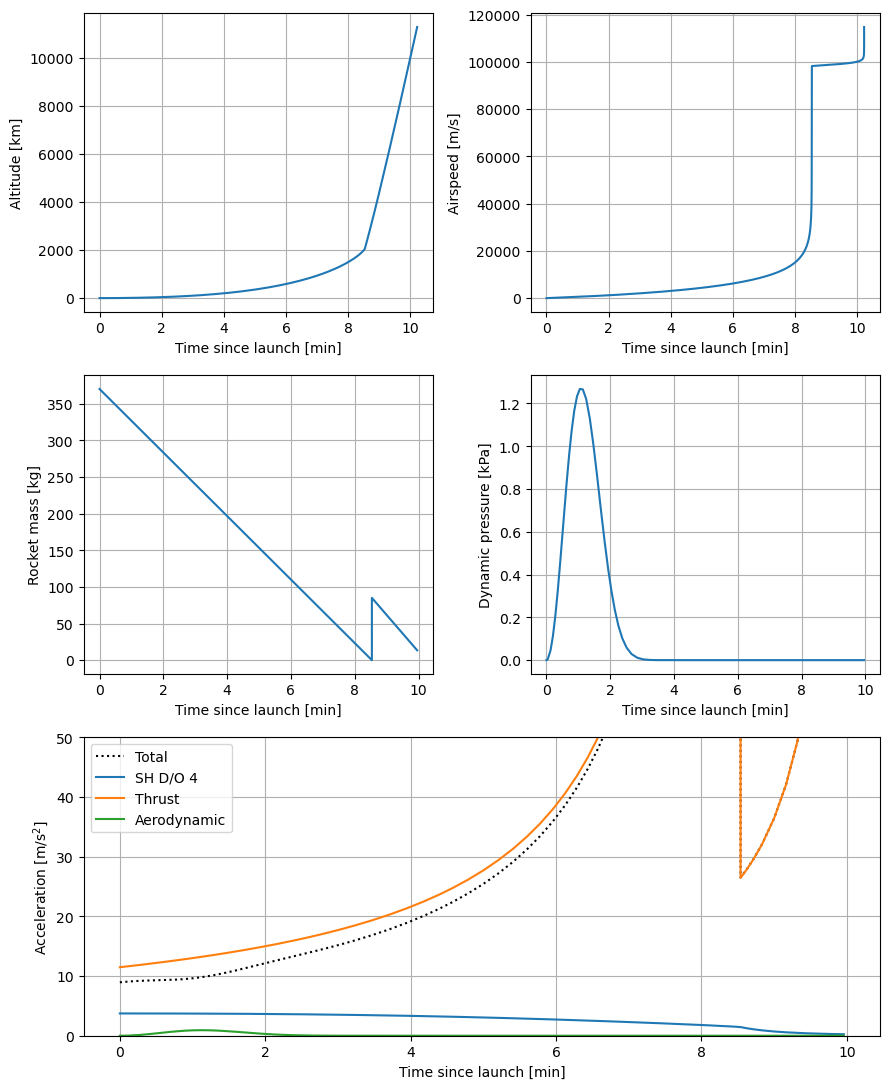

In [95]:
print("Stage separation occured after %.2f minutes." % ((final_epoch_section_1-times[0])/60))

# Compute the index at which the time since launch gets above 10 minutes
idx_crop = np.where(times_since_launch/60 >= 10)[0][:]
if len(idx_crop) == 0:
    idx_crop = len(times_since_launch)-1
else:
    idx_crop = idx_crop[0]
    
# Create a figure with 5 subplots: a grid of 2x2, then one horizontal one at the bottom
fig = plt.figure(figsize=(9, 11))
gs = fig.add_gridspec(3, 2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 =fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])
ax5 = fig.add_subplot(gs[2, :])

# Plot the altitude history
ax1.plot(times_since_launch/60, altitudes/1e3)
ax1.grid()
ax1.set_xlabel("Time since launch [min]")
ax1.set_ylabel("Altitude [km]")

# Plot the airspeed history
ax2.plot(times_since_launch/60, airspeeds)
ax2.grid()
ax2.set_xlabel("Time since launch [min]")
ax2.set_ylabel("Airspeed [m/s]")

# Plot the mass history in the first 10 minutes
ax3.plot(times_since_launch[:idx_crop]/60, mass[:idx_crop])
ax3.grid()
ax3.set_xlabel("Time since launch [min]")
ax3.set_ylabel("Rocket mass [kg]")

# Plot the dynamic pressure history in the first 10 minutes
ax4.plot(times_since_launch[:idx_crop]/60, dyna_pressures[:idx_crop]/1e3)
ax4.grid()
ax4.set_xlabel("Time since launch [min]")
ax4.set_ylabel("Dynamic pressure [kPa]")

# Plot the accelerations history in the first 10 minutes
ax5.plot(times_since_launch[:idx_crop]/60, total_a[:idx_crop], label="Total", linestyle="dotted", color="black")
ax5.plot(times_since_launch[:idx_crop]/60, SH_a[:idx_crop], label="SH D/O 4")
ax5.plot(times_since_launch[:idx_crop]/60, thrust_a[:idx_crop], label="Thrust")
ax5.plot(times_since_launch[:idx_crop]/60, aero_a[:idx_crop], label="Aerodynamic")
ax5.grid()
ax5.set_xlabel("Time since launch [min]")
ax5.set_ylabel("Acceleration [m/s$^2$]")
#ax5.set_yscale("log") # (uncomment this to see the distinction between the accelerations more clearly)
ax5.legend()
ax5.set_ylim([0, 50])

# Save some space using a tight layout, and show the figure
plt.tight_layout()
plt.show()

### Results analysis
Finally, we can analyse the plot that we produce, giving various insights in our numerical simulation of a two-stage rocket ascent on Mars.

#### Altitude over time
In the first plot on the top left, we can see the altitude plotted as a function of time. This shows that the rocket progressively gains more and more altitude, as its accelerates. After stage separation, at around 9min, when the second stage ignites, the rocket does not gain significantly more altitude. This is because the second stage fires only horizontally. Because it does so at apoapsis, it fires only prograde, increasing the prograde (horizontal) velocity of the rocket, without increasing its radial (vertical) velocity. Afterwards, we see oscillations between around 150km and 900km. This shows that our vehicle is now in orbit.

#### Airspeed over time
The second plot on the top right clearly shows that the rocket gains considerable speed in the first seconds, when the first stage fires. At first stage burnout, the velocity starts decreasing. This is because we loose velocity for altitude, until we reach apoapsis. At apoapsis, the second stage ignites, and the velocity increases considerably again. Afterwards, we see oscillations between around 3.4 and 2.7 km/s, showing that our vehicle is at orbital velocity around Mars.

#### Rocket mass over time
The thrist plot in the middle left shows the mass of our rocket over time in its first 10 minutes. We can clearly identify the two moments where the rocket burns propellant, indicated by the two sections where the mass linearly decreases, from 0min to 2min, and from 9min to 10min. During the burns, since the rocket has a thrust magnitude that is 1.75 times higher in the first 15 seconds, it also looses propellant 1.75 times faster. This can be seen by the higher mass rate at the beginning of the ignition of both stages.
Finally, we can see at around 9min that the two stages separate, because our rocket mass instantaneously changes from 185kg to 85kg.

#### Dynamic pressure over time
The fourth plot, in the middle right, shows the dynamic pressure over time in front of our rocket. While the model used to compute it is rather simplistic, it still gives a good indication as when max-q (moment of maximum dynamic pressure) is reached, and of its magnitude. This maximum dynamic pressure may be lower than expected, since we are flying on Mars and not the Earth.

#### Accelerations over time
Finally, the plot at the bottom shows various accelerations over time. Clearly, thrust gives the acceleration of the highest magnitude. Once again, we can see that the thrust was each time of a mgnitude 1.75 times higher in the first 15 seconds. Also, we can see that the thrust acceleration increases over time furing each of the burn. This can be expected: the acceleration that results in the thrust force becomes higher over time as our rocket mass becomes lower.
The Martian gravitational acceleration comes second in magnitude. While it appears constant, because its magnitude is much lower than the one of the thrst, this gravitational acceleration decreases as altitude increases.
Finally, the aerodynamic acceleration is only significant in the first 2min of the ascent. One may realise that this acceleration follows a similar shape as the dynamic pressure over time. This is because the aerodynamic acceleration relies purely on the aerodynamic coefficients (which are constant in this case), the angle of attack (that varies only between -2deg and 2deg), and the dynamic pressure.